### Загрузка RAVDESS 

In [1]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
from sklearn.cluster import KMeans

In [2]:
lst = []
emotion = []
voc_channel = []
full_path = []
modality = []
intensity = []
actors = []
phrase =[]

for root, dirs, files in tqdm(os.walk("RAVDESS")):
    for file in files:
        try:
            # Собираем разметку с файла согласно нотации датасета
           
            modal = int(file[1:2])
            vchan = int(file[4:5])
            lab = int(file[7:8])
            ints = int(file[10:11])
            phr = int(file[13:14])
            act = int(file[19:20])
            
            
            modality.append(modal)
            voc_channel.append(vchan)
            emotion.append(lab) 
            intensity.append(ints)
            phrase.append(phr)
            actors.append(act)
            
            full_path.append((root, file)) 

        except ValueError:
            continue

0it [00:00, ?it/s]

In [3]:
# Строим датафрейм

emotions_list = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
emotion_dict = {em[0]+1:em[1] for em in enumerate(emotions_list)}

df = pd.DataFrame([emotion, voc_channel, modality, intensity, actors, phrase, full_path]).T
df.columns = ['emotion', 'voc_channel', 'modality', 'intensity', 'actors', 'phrase', 'path']
df['emotion'] = df['emotion'].map(emotion_dict)
df['voc_channel'] = df['voc_channel'].map({1: 'speech', 2:'song'})
df['modality'] = df['modality'].map({1: 'full AV', 2:'video only', 3:'audio only'})
df['intensity'] = df['intensity'].map({1: 'normal', 2:'strong'})
df['actors'] = df['actors'].apply(lambda x: 'female' if x%2 == 0 else 'male')
df['phrase'] = df['phrase'].map({1: 'Kids are talking by the door', 2:'Dogs are sitting by the door'})
df['path'] = df['path'].apply(lambda x: x[0] + '/' + x[1])

df.head()

,emotion,voc_channel,modality,intensity,actors,phrase,path
0,surprised,speech,audio only,normal,female,Dogs are sitting by the door,RAVDESS/Actor_08/03-01-08-01-02-02-08.wav
1,angry,speech,audio only,normal,female,Kids are talking by the door,RAVDESS/Actor_08/03-01-05-01-01-01-08.wav
2,sad,speech,audio only,normal,female,Kids are talking by the door,RAVDESS/Actor_08/03-01-04-01-01-02-08.wav
3,angry,speech,audio only,strong,female,Kids are talking by the door,RAVDESS/Actor_08/03-01-05-02-01-02-08.wav
4,surprised,speech,audio only,strong,female,Dogs are sitting by the door,RAVDESS/Actor_08/03-01-08-02-02-02-08.wav


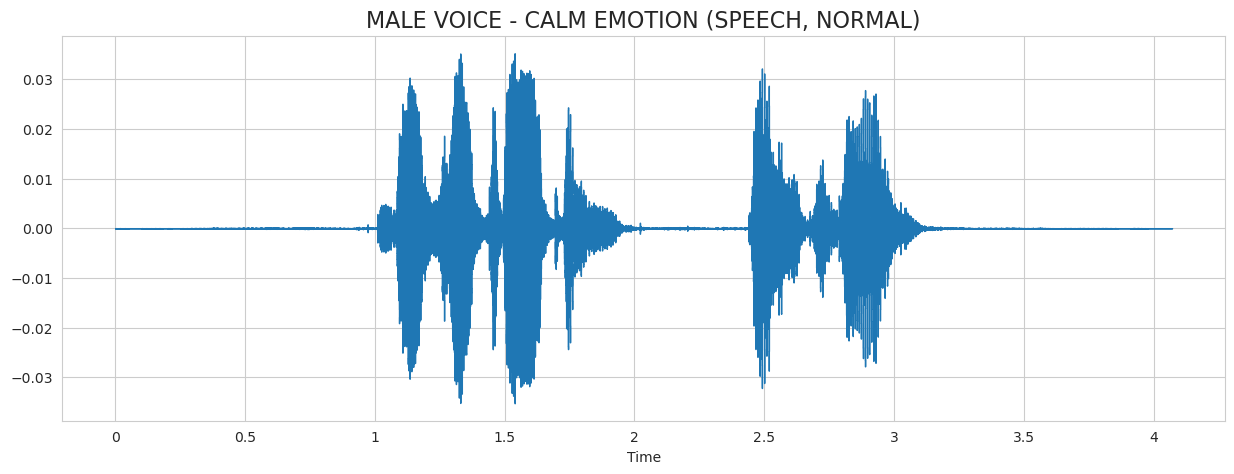

In [4]:
# Визуализируем данные из датафрейма
n_files = df.shape[0]

rnd = np.random.randint(0,n_files)

fname = df.path[rnd] 
data, sampling_rate = librosa.load(fname, sr=44100)

plt.figure(figsize=(15, 5))
info = df.iloc[rnd].values
title_txt = f'{info[4]} voice - {info[0]} emotion ({info[1]}, {info[3]})'
plt.title(title_txt.upper(), size=16)
librosa.display.waveshow(data, sr=sampling_rate)

ipd.Audio(fname)

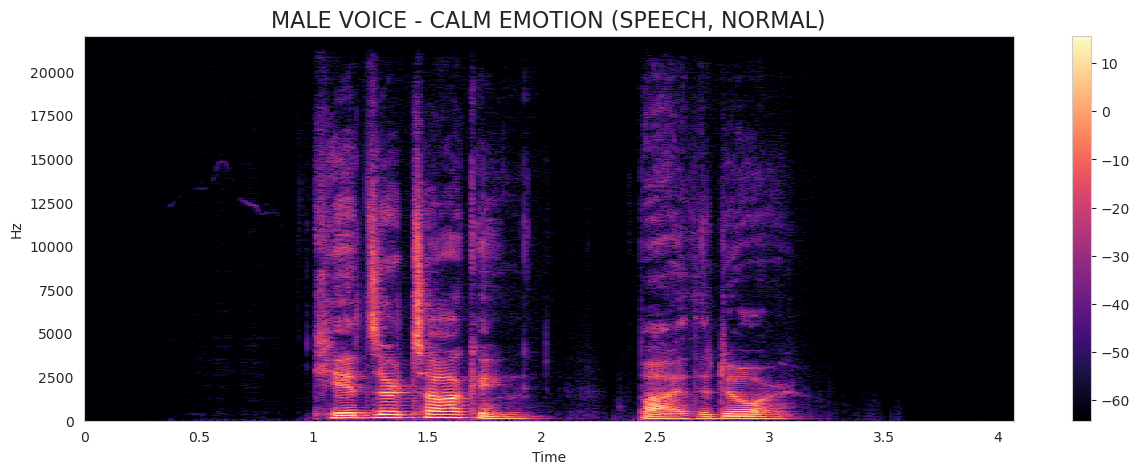

In [5]:
# Строим спектрограмму

X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title(title_txt.upper(), size=16)
plt.show()

In [6]:
mfccs = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc = 40) # Mel-frequency cepstral coefficients

In [7]:
data.shape, Xdb.shape, mfccs.shape

((179520,), (1025, 351), (40, 351))

### SAVEE

In [8]:
SAVEE = os.path.join('', "SAVEE/")
dir_list = os.listdir(SAVEE)

# Парсим данные согласно разметки
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('angry_male')
    elif i[-8:-6]=='_d':
        emotion.append('disgust_male')
    elif i[-8:-6]=='_f':
        emotion.append('fear_male')
    elif i[-8:-6]=='_h':
        emotion.append('happy_male')
    elif i[-8:-6]=='_n':
        emotion.append('neutral_male')
    elif i[-8:-6]=='sa':
        emotion.append('sad_male')
    elif i[-8:-6]=='su':
        emotion.append('surprise_male')
    else:
        emotion.append('Unknown') 
    path.append(SAVEE + i)
    
SAVEE_df = pd.DataFrame(emotion, columns = ['emotion_label'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.emotion_label.value_counts()

neutral_male     120
sad_male          60
disgust_male      60
surprise_male     60
happy_male        60
angry_male        60
fear_male         60
Name: emotion_label, dtype: int64

In [9]:
SAVEE_df.head()

,emotion_label,source,path
0,sad_male,SAVEE,SAVEE/JE_sa09.wav
1,disgust_male,SAVEE,SAVEE/KL_d12.wav
2,disgust_male,SAVEE,SAVEE/JK_d09.wav
3,sad_male,SAVEE,SAVEE/KL_sa10.wav
4,surprise_male,SAVEE,SAVEE/JE_su13.wav


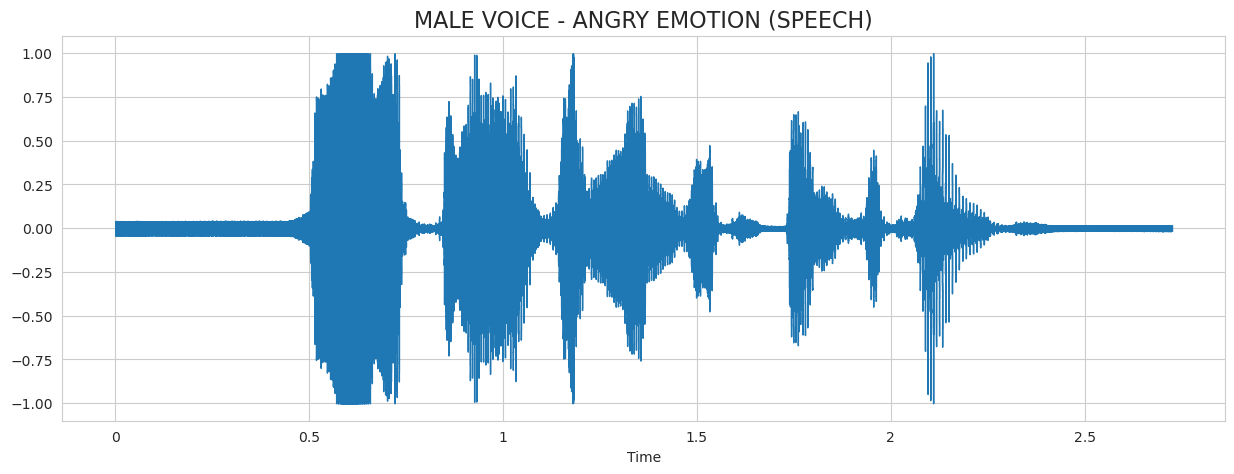

In [10]:
# Визуализируем данные из датафрейма

n_files = SAVEE_df.shape[0]

rnd = np.random.randint(0,n_files)

fname = SAVEE_df.path[rnd] 
data, sampling_rate = librosa.load(fname, sr=44100)

plt.figure(figsize=(15, 5))
info = SAVEE_df.iloc[rnd].values
title_txt = f'male voice - {info[0][:-5]} emotion (speech)'
plt.title(title_txt.upper(), size=16)
librosa.display.waveshow(data, sr=sampling_rate)

# play the audio 
ipd.Audio(fname)

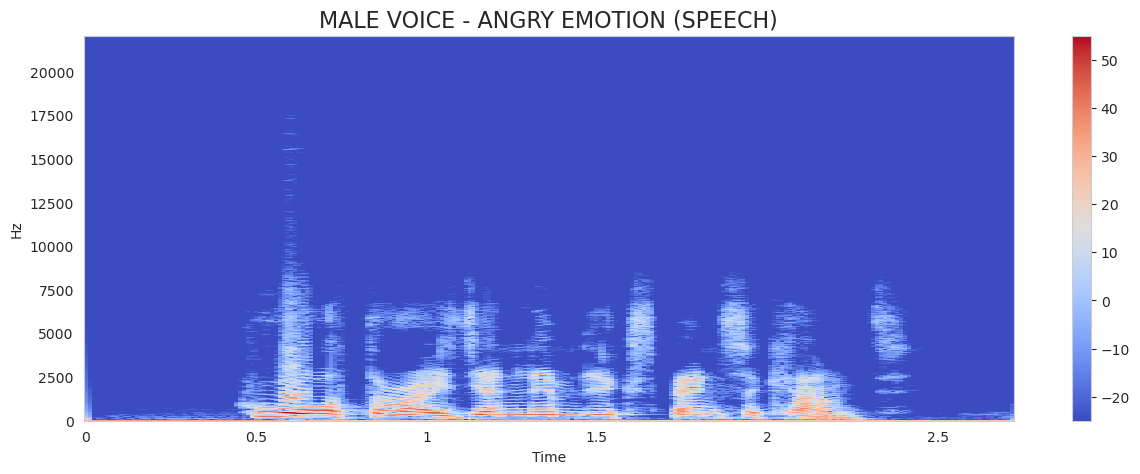

In [11]:
# Строим спектрограмму

X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title(title_txt.upper(), size=16)
plt.show()

In [12]:
data.shape, Xdb.shape

((120188,), (1025, 235))

### TESS

In [13]:
TESS = os.path.join('', "TESS/")
dir_list = os.listdir(TESS)
dir_list.sort()
dir_list

['OAF_Fear',
 'OAF_Pleasant_surprise',
 'OAF_Sad',
 'OAF_angry',
 'OAF_disgust',
 'OAF_happy',
 'OAF_neutral',
 'TESS Toronto emotional speech set data',
 'YAF_angry',
 'YAF_disgust',
 'YAF_fear',
 'YAF_happy',
 'YAF_neutral',
 'YAF_pleasant_surprised',
 'YAF_sad']

In [14]:
path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('angry_female')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('disgust_female')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('fear_female')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('happy_female')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('neutral_female')                                
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('surprise_female')               
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('sad_female')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['emotion_label'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.emotion_label.value_counts()

fear_female        400
surprise_female    400
sad_female         400
angry_female       400
disgust_female     400
happy_female       400
neutral_female     400
Unknown             14
Name: emotion_label, dtype: int64

In [15]:
TESS_df.head()

,emotion_label,source,path
0,fear_female,TESS,TESS/OAF_Fear/OAF_ton_fear.wav
1,fear_female,TESS,TESS/OAF_Fear/OAF_mob_fear.wav
2,fear_female,TESS,TESS/OAF_Fear/OAF_bought_fear.wav
3,fear_female,TESS,TESS/OAF_Fear/OAF_sell_fear.wav
4,fear_female,TESS,TESS/OAF_Fear/OAF_doll_fear.wav


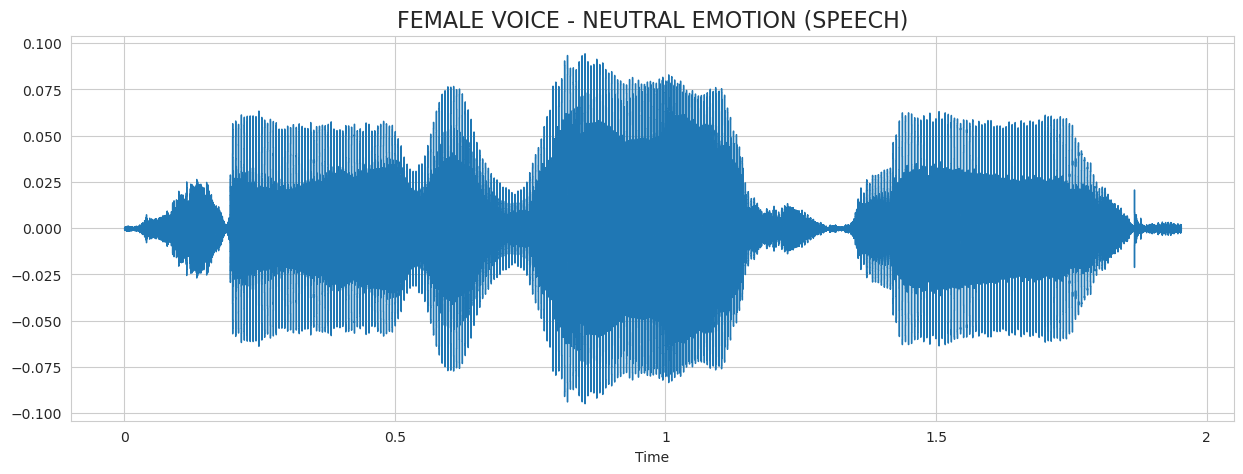

In [16]:
# Визуализируем данные из датафрейма

n_files = TESS_df.shape[0]

rnd = np.random.randint(0,n_files)

fname = TESS_df.path[rnd] 
data, sampling_rate = librosa.load(fname, sr=44100)

plt.figure(figsize=(15, 5))
info = TESS_df.iloc[rnd].values
title_txt = f'female voice - {info[0][:-7]} emotion (speech)'
plt.title(title_txt.upper(), size=16)
librosa.display.waveshow(data, sr=sampling_rate)

ipd.Audio(fname)
     

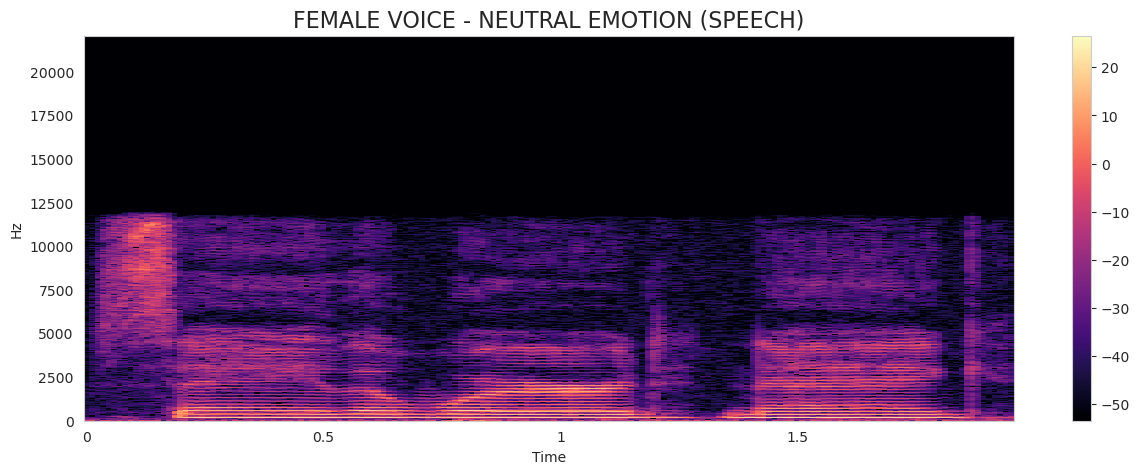

In [17]:
# Строим спектрограмму

X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title(title_txt.upper(), size=16)
plt.show()

In [18]:

data.shape, Xdb.shape

((86096,), (1025, 169))

### CREMA-D

In [21]:
CREMA = os.path.join('', 'CREMA-D/')

dir_list = os.listdir(CREMA)
dir_list.sort()
dir_list[:5]

['1001_DFA_ANG_XX.wav',
 '1001_DFA_DIS_XX.wav',
 '1001_DFA_FEA_XX.wav',
 '1001_DFA_HAP_XX.wav',
 '1001_DFA_NEU_XX.wav']

In [24]:
# Собираем данные по разметке

emotion = []
gender = []
path = []
female_ids = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,
              1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,1052,1053,1054,
              1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,
              1082,1084,1089,1091]

temp_dict = {"SAD":"sad", "ANG": "angry", "DIS":"disgust", "FEA":"fear", 
             "HAP":"happy", "NEU":"neutral"}

def get_emotion_crema(filename, ids=female_ids, dc=temp_dict):
  filename = filename.split("_")
  emotion1 = dc[filename[2]]
  if int(filename[0]) in ids:
    emotion2 = "_female"
  else:
    emotion2 = "_male"
  emotion = emotion1 + emotion2
  return (emotion, emotion2[1:])

for i in dir_list: 
  emotion.append(get_emotion_crema(i)[0])
  gender.append(get_emotion_crema(i)[1])
  path.append(CREMA + i)
    
CREMA_df = pd.DataFrame(emotion, columns = ['emotion_label'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(gender, columns = ['actors'])],axis=1)
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.emotion_label.value_counts()

angry_male        671
disgust_male      671
fear_male         671
happy_male        671
sad_male          671
angry_female      600
disgust_female    600
fear_female       600
happy_female      600
sad_female        600
neutral_male      575
neutral_female    512
Name: emotion_label, dtype: int64

In [25]:
CREMA_df.head()

,emotion_label,source,actors,path
0,angry_male,CREMA,male,CREMA-D/1001_DFA_ANG_XX.wav
1,disgust_male,CREMA,male,CREMA-D/1001_DFA_DIS_XX.wav
2,fear_male,CREMA,male,CREMA-D/1001_DFA_FEA_XX.wav
3,happy_male,CREMA,male,CREMA-D/1001_DFA_HAP_XX.wav
4,neutral_male,CREMA,male,CREMA-D/1001_DFA_NEU_XX.wav


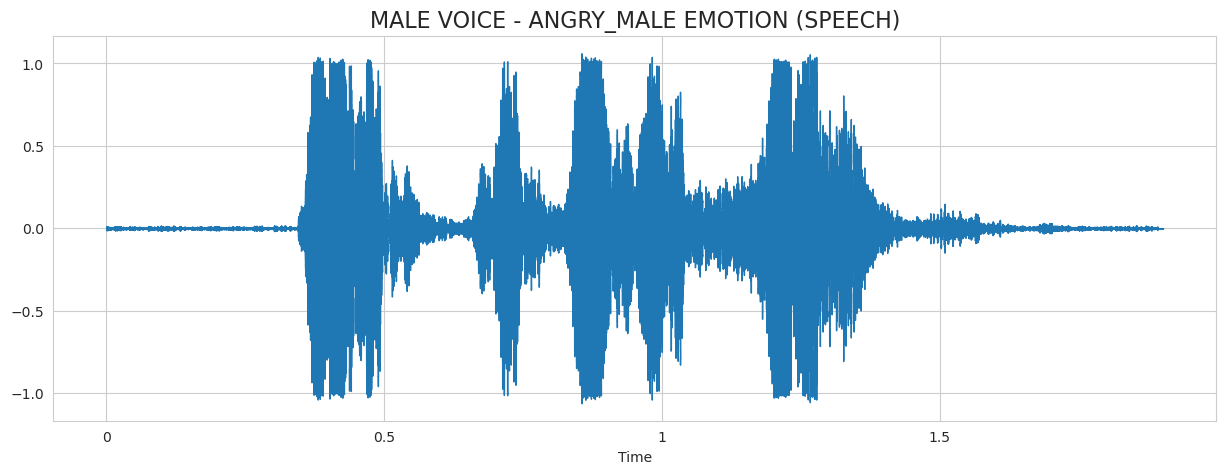

In [26]:
# Визуализируем
n_files = CREMA_df.shape[0]

# choose random number
rnd = np.random.randint(0,n_files)

# use the Librosa library to load and plot the random speech
fname = CREMA_df.path[rnd] 
data, sampling_rate = librosa.load(fname, sr=44100)

plt.figure(figsize=(15, 5))
info = CREMA_df.iloc[rnd].values
title_txt = f'{info[2]} voice - {info[0]} emotion (speech)'
plt.title(title_txt.upper(), size=16)
librosa.display.waveshow(data, sr=sampling_rate)

# play the audio 
ipd.Audio(fname)

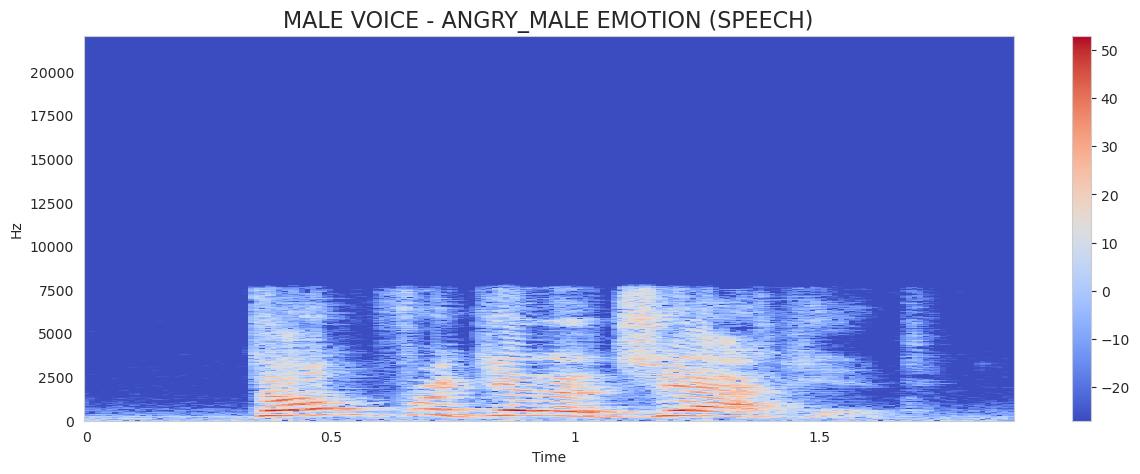

In [27]:
# Спектрограмма

X = librosa.stft(data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(15, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()
plt.title(title_txt.upper(), size=16)
plt.show()

### Сообираем

In [28]:
df.head()

,emotion,voc_channel,modality,intensity,actors,phrase,path
0,surprised,speech,audio only,normal,female,Dogs are sitting by the door,RAVDESS/Actor_08/03-01-08-01-02-02-08.wav
1,angry,speech,audio only,normal,female,Kids are talking by the door,RAVDESS/Actor_08/03-01-05-01-01-01-08.wav
2,sad,speech,audio only,normal,female,Kids are talking by the door,RAVDESS/Actor_08/03-01-04-01-01-02-08.wav
3,angry,speech,audio only,strong,female,Kids are talking by the door,RAVDESS/Actor_08/03-01-05-02-01-02-08.wav
4,surprised,speech,audio only,strong,female,Dogs are sitting by the door,RAVDESS/Actor_08/03-01-08-02-02-02-08.wav


In [29]:
RAV_df = df.copy()

# только речь
RAV_df = RAV_df.loc[RAV_df.voc_channel == 'speech']

RAV_df.insert(0, "emotion_label", RAV_df.emotion+'_'+RAV_df.actors, True)
RAV_df.insert(1, "source", "RAV", True)
RAV_df = RAV_df.drop(['emotion', 'voc_channel', 'modality', 'intensity', 'phrase'], 1)
RAV_df.head()

,emotion_label,source,actors,path
0,surprised_female,RAV,female,RAVDESS/Actor_08/03-01-08-01-02-02-08.wav
1,angry_female,RAV,female,RAVDESS/Actor_08/03-01-05-01-01-01-08.wav
2,sad_female,RAV,female,RAVDESS/Actor_08/03-01-04-01-01-02-08.wav
3,angry_female,RAV,female,RAVDESS/Actor_08/03-01-05-02-01-02-08.wav
4,surprised_female,RAV,female,RAVDESS/Actor_08/03-01-08-02-02-02-08.wav


In [30]:
TESS_df.insert(2, "actors", "female", True)
SAVEE_df.insert(2, "actors", "male", True)

In [31]:
df_combined = pd.concat([TESS_df, RAV_df, SAVEE_df, CREMA_df])
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12176 entries, 0 to 7441
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   emotion_label  12176 non-null  object
 1   source         12176 non-null  object
 2   actors         12176 non-null  object
 3   path           12176 non-null  object
dtypes: object(4)
memory usage: 475.6+ KB


In [32]:
for col in ['emotion_label', 'source', 'actors']:
    print('\nColumn values for ', col.upper())
    print(df_combined[col].value_counts())


Column values for  EMOTION_LABEL
sad_female          1096
angry_female        1096
disgust_female      1096
happy_female        1096
fear_female         1000
neutral_female       960
angry_male           827
disgust_male         827
happy_male           827
sad_male             827
neutral_male         743
fear_male            731
surprise_female      400
calm_male             96
fearful_male          96
fearful_female        96
surprised_female      96
surprised_male        96
calm_female           96
surprise_male         60
Unknown               14
Name: emotion_label, dtype: int64

Column values for  SOURCE
CREMA    7442
TESS     2814
RAV      1440
SAVEE     480
Name: source, dtype: int64

Column values for  ACTORS
female    7046
male      5130
Name: actors, dtype: int64


In [33]:
new_labels_dict_comb = {'angry_male':'negative_male', 'angry_female':'negative_female', 
                        'calm_male':'neutral_male', 'calm_female':'neutral_female',
                        'disgust_male':'negative_male', 'disgust_female':'negative_female', 
                        'fearful_male':'negative_male','fearful_female':'negative_female',
                        'fear_male':'negative_male', 'fear_female':'negative_female',
                        'happy_male':'positive_male', 'happy_female':'positive_female',
                        'neutral_male':'neutral_male', 'neutral_female':'neutral_female',
                        'sad_male':'negative_male', 'sad_female':'negative_female',
                        'surprised_male':'positive_male', 'surprised_female':'positive_female',
                        'surprise_male':'positive_male', 'surprise_female':'positive_female',
                        'Unknown': 'unk'}

df_combined['emotion2'] = df_combined['emotion_label'].map(new_labels_dict_comb)
df_combined.head()

,emotion_label,source,actors,path,emotion2
0,fear_female,TESS,female,TESS/OAF_Fear/OAF_ton_fear.wav,negative_female
1,fear_female,TESS,female,TESS/OAF_Fear/OAF_mob_fear.wav,negative_female
2,fear_female,TESS,female,TESS/OAF_Fear/OAF_bought_fear.wav,negative_female
3,fear_female,TESS,female,TESS/OAF_Fear/OAF_sell_fear.wav,negative_female
4,fear_female,TESS,female,TESS/OAF_Fear/OAF_doll_fear.wav,negative_female


In [34]:
addit_labels_dict_comb = {'angry_male':'negative_male', 'angry_female':'negative_female', 
                        'calm_male':'neutral_male', 'calm_female':'neutral_female',
                        'disgust_male':'negative_male', 'disgust_female':'negative_female', 
                        'fearful_male':'fear_male','fearful_female':'fear_female',
                        'fear_male':'fear_male', 'fear_female':'fear_female',
                        'happy_male':'positive_male', 'happy_female':'positive_female',
                        'neutral_male':'neutral_male', 'neutral_female':'neutral_female',
                        'sad_male':'sad_male', 'sad_female':'sad_female',
                        'surprised_male':'surprise_male', 'surprised_female':'surprise_female',
                        'surprise_male':'surprise_male', 'surprise_female':'surprise_female',
                        'Unknown': 'unk'}

df_combined['emotion3'] = df_combined['emotion_label'].map(addit_labels_dict_comb)
df_combined.head()

,emotion_label,source,actors,path,emotion2,emotion3
0,fear_female,TESS,female,TESS/OAF_Fear/OAF_ton_fear.wav,negative_female,fear_female
1,fear_female,TESS,female,TESS/OAF_Fear/OAF_mob_fear.wav,negative_female,fear_female
2,fear_female,TESS,female,TESS/OAF_Fear/OAF_bought_fear.wav,negative_female,fear_female
3,fear_female,TESS,female,TESS/OAF_Fear/OAF_sell_fear.wav,negative_female,fear_female
4,fear_female,TESS,female,TESS/OAF_Fear/OAF_doll_fear.wav,negative_female,fear_female


In [35]:

df_combined.emotion2.value_counts()

negative_female    4384
negative_male      3308
positive_female    1592
neutral_female     1056
positive_male       983
neutral_male        839
unk                  14
Name: emotion2, dtype: int64

In [36]:
df_combined.emotion3.value_counts()

negative_female    2192
negative_male      1654
fear_female        1096
sad_female         1096
positive_female    1096
neutral_female     1056
neutral_male        839
fear_male           827
sad_male            827
positive_male       827
surprise_female     496
surprise_male       156
unk                  14
Name: emotion3, dtype: int64

In [37]:
df_combined = df_combined.loc[df_combined['emotion2'] != 'unk']

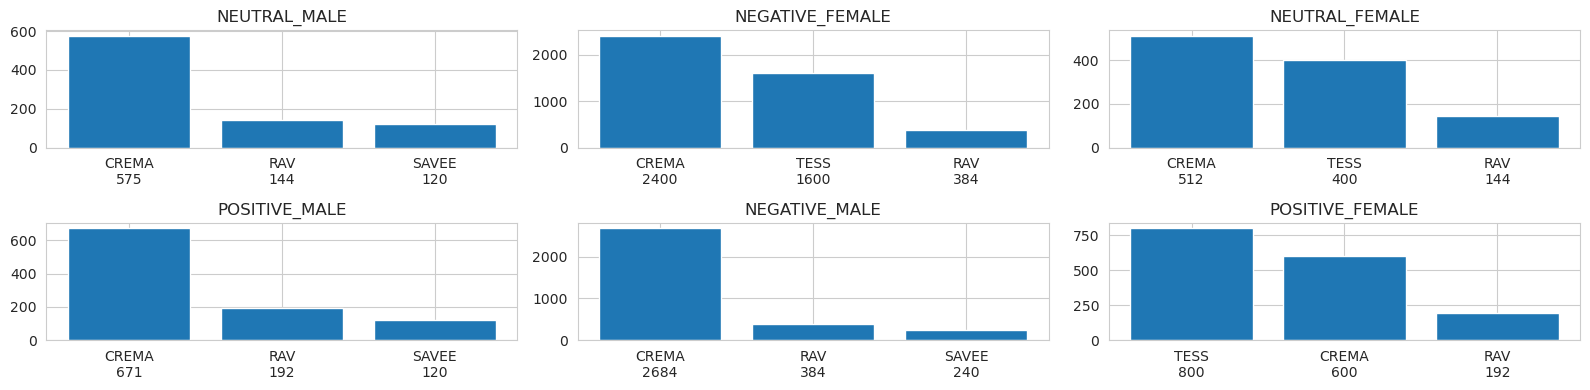

In [38]:
fig, ax = plt.subplots(2, 3, figsize=(16,4))
for idx, emotion_ in enumerate(set(df_combined['emotion2'].values)):
    pdata = df_combined.loc[df_combined.emotion2 == emotion_]
    names= pdata['source'].value_counts().index
    values= pdata['source'].value_counts().values
    names = [n[0]+'\n'+str(n[1]) for n in zip(names,values)]
    plt.subplot(2,3,idx+1)
    plt.bar(names, values)
    plt.title(emotion_.upper())
plt.tight_layout()
plt.show()

In [39]:
df_combined.emotion2.value_counts()

negative_female    4384
negative_male      3308
positive_female    1592
neutral_female     1056
positive_male       983
neutral_male        839
Name: emotion2, dtype: int64

In [40]:
df_combined["id"] = df_combined.index + 0
df_combined["id"] = df_combined["id"].astype(str)
df_combined.head()

,emotion_label,source,actors,path,emotion2,emotion3,id
0,fear_female,TESS,female,TESS/OAF_Fear/OAF_ton_fear.wav,negative_female,fear_female,0
1,fear_female,TESS,female,TESS/OAF_Fear/OAF_mob_fear.wav,negative_female,fear_female,1
2,fear_female,TESS,female,TESS/OAF_Fear/OAF_bought_fear.wav,negative_female,fear_female,2
3,fear_female,TESS,female,TESS/OAF_Fear/OAF_sell_fear.wav,negative_female,fear_female,3
4,fear_female,TESS,female,TESS/OAF_Fear/OAF_doll_fear.wav,negative_female,fear_female,4


In [42]:
df_combined.to_csv(os.path.join('',"combined_all4.csv"), index=False)

In [43]:
path0 = os.path.join('', 'combined_all4.csv')

df_combined = pd.read_csv(path0)
df_combined.head()

,emotion_label,source,actors,path,emotion2,emotion3,id
0,fear_female,TESS,female,TESS/OAF_Fear/OAF_ton_fear.wav,negative_female,fear_female,0
1,fear_female,TESS,female,TESS/OAF_Fear/OAF_mob_fear.wav,negative_female,fear_female,1
2,fear_female,TESS,female,TESS/OAF_Fear/OAF_bought_fear.wav,negative_female,fear_female,2
3,fear_female,TESS,female,TESS/OAF_Fear/OAF_sell_fear.wav,negative_female,fear_female,3
4,fear_female,TESS,female,TESS/OAF_Fear/OAF_doll_fear.wav,negative_female,fear_female,4


In [45]:
class DatasetSelector:
  def __init__(self, df, label='emotion2', src='source', path='path', 
               subclass='actors'):
    """
    Format: df.columns = [label, source, actors, path]
    """
    self.df = df
    self.label = label
    self.path = path
    self.subclass = subclass
    self.src = src

  def select(self, source=None, subclass=None, balanced=True, verbose=False):
    """
    Собирает файлы из датасета по параметрам
    source: Список источников
    subclass: Имя колонки
    balanced: True/False - балансировать или нет
    """
    df = self.df

    if not source is None:
      df = df.loc[(df[self.src].isin(source))]

    if not subclass is None:
      df = df.loc[(df[self.subclass]==subclass)]

    if balanced:
      label_counts = df[self.label].value_counts().values
      label_names = df[self.label].value_counts().index
      balanced = np.min(label_counts)

      sub_df_list =[]
      for lab in df[self.label].unique():
        sub_df = df.loc[(df[self.label]==lab)]
        sub_df_list.append(sub_df.sample(balanced))

      df = pd.concat(sub_df_list)

    print(f"New shape: {df.shape}") 
    if balanced and verbose:
      print(df[self.label].value_counts())  

    return df
  
  def load_mfccs(self, source=None, subclass=None, balanced=True):
    """
    Возвращает массив mfccs для выбранного датафрейма
    """
    df = self.select(source, subclass, balanced, verbose=True)
    arr_mfccs = []
    
    for path in tqdm(df[self.path].values):
        a1, a2, a3 = get_audio_data(path, calculate_mfccs=True)
        arr_mfccs.append(a3)

    return (arr_mfccs, df[self.label].values)

In [46]:
ds = DatasetSelector(df_combined)
balanced_df = ds.select(subclass='female', source=['TESS', 'CREMA'])

New shape: (2736, 7)


In [47]:
balanced_df.emotion2.value_counts()

negative_female    912
positive_female    912
neutral_female     912
Name: emotion2, dtype: int64

In [48]:
balanced_df.head()

,emotion_label,source,actors,path,emotion2,emotion3,id
11078,angry_female,CREMA,female,CREMA-D/1078_TIE_ANG_XX.wav,negative_female,negative_female,6358
460,sad_female,TESS,female,TESS/OAF_Sad/OAF_chalk_sad.wav,negative_female,sad_female,460
733,angry_female,TESS,female,TESS/OAF_angry/OAF_white_angry.wav,negative_female,negative_female,733
9119,fear_female,CREMA,female,CREMA-D/1054_TSI_FEA_XX.wav,negative_female,fear_female,4399
4952,sad_female,CREMA,female,CREMA-D/1003_TIE_SAD_XX.wav,negative_female,sad_female,232


In [49]:
balanced_df.describe()

,id
count,2736.000000
mean,2601.879751
std,2003.845743
min,12.000000
25%,1086.750000
50%,2129.000000
75%,4166.250000
max,7441.000000


In [50]:
balanced_df.to_csv("combined_all4_balanced.csv")